# The Poutyne Model

### Loading Libraries

In [2]:
# Numerical Computing
import math
import numpy as np

# Data Malipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST
from torch.utils.data import Subset, DataLoader

# Poutyne 
from poutyne import set_seeds, Model

In [3]:
# Setting Seeds
set_seeds(42)

In [4]:
# Cudas
cuda_device = 0

# Device
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

In [5]:
# Model Splits
train_split_percent = 0.8

# Classes
num_classes = 10

# Batch
batch_size = 32

#Learning Rate
learning_rate = 0.1

# Epochs
num_epochs = 1

In [6]:
full_train_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./mnist/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

split = math.floor(train_split_percent * num_data)

train_indices = indices[:split]
train_dataset = Subset(full_train_dataset, train_indices)

valid_indices = indices[split:]
valid_dataset = Subset(full_train_dataset, valid_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

loaders = train_loader, valid_loader, test_loader

100%|██████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 21.8MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 472kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.43MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.70MB/s]


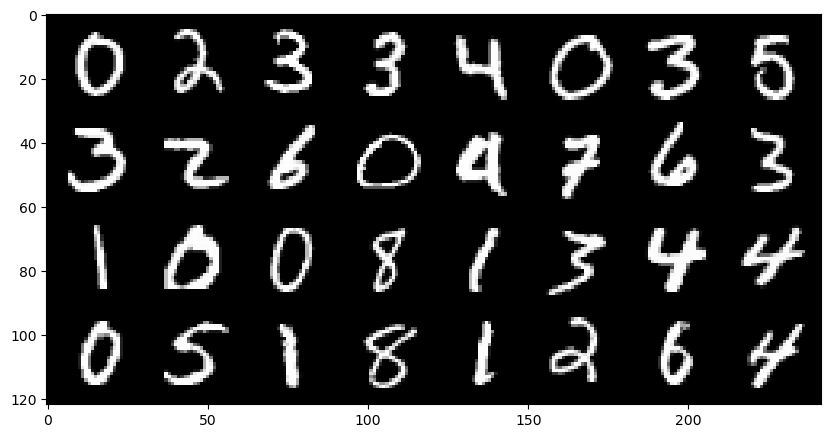

In [7]:
inputs = next(iter(train_loader))[0]
input_grid = utils.make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

#### Convolutional Network Function:

In [8]:
def create_convolutional_network():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

#### `Poutyne Model` Function:

In [9]:
def poutyne_train(pytorch_network):
    print(pytorch_network)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Poutyne Model
    model = Model(pytorch_network, optimizer, loss_function, batch_metrics=['accuracy'])

    # Send model on GPU
    model.to(device)

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [10]:
conv_net = create_convolutional_network()
poutyne_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1/1 Train steps: 1500 Val steps: 375 9.51s loss: 0.398043 acc: 87.177083 val_loss: 0.091635 val_acc: 97.275000
Test steps: 313 1.66s test_loss: 0.083661 test_acc: 97.380000                                    
Test:
	Loss: 0.0836612139787525
	Accuracy: 97.38
